In [47]:
import csv
import re
from collections import Counter
from itertools import combinations
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
import yaml
import os
config_path = os.path.join("..", "config.yaml")
# Load the configuration file
with open(config_path, "r") as f:
    config = yaml.safe_load(f)
    EMOTIONS, RANDOM_SEED = (
        config["EMOTIONS"],
        config["RANDOM_SEED"],
    )

def safe_eval(s):
    try:
        s = s.strip().strip("'\"")
        match = re.match(r'\[(.*)\]', s)
        if match:
            content = match.group(1)
            return [item.strip().strip("'\"") for item in content.split(',') if item.strip()]
        else:
            return []
    except:
        print(f"Warning: Could not parse '{s}'. Returning empty list.")
        return []

def process_csv(file_path):
    data = []
    empty_predictions = 0
    with open(file_path, 'r', encoding='utf-8') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            predictions = safe_eval(row['parsed_predictions'])
            if not predictions:
                empty_predictions += 1
            data.append(predictions)
    print(f"Number of empty predictions: {empty_predictions}")
    return data

def get_top_pairs(data, n=15):
    pair_counter = Counter(tuple(sorted(pred)) for pred in data if pred)
    return pair_counter.most_common(n)

def get_all_emotion_pairs(data, n=15):
    all_pairs = list(combinations(EMOTIONS, 2))
    pair_counter = Counter()
    
    for pred in data:
        pred_set = set(pred)
        for pair in all_pairs:
            if set(pair).issubset(pred_set):
                pair_counter[pair] += 1
    
    return pair_counter.most_common(n)

def print_table(data, title):
    df = pd.DataFrame(data, columns=['Emotions', 'Count'])
    df['Emotions'] = df['Emotions'].apply(lambda x: ', '.join(x))
    print(f"\n{title}")
    print(tabulate(df, headers='keys', tablefmt='fancy_grid', showindex=False))

def plot_top_pairs(data, title, run_number, save=False, set_="train"):
    emotions, counts = zip(*data)
    emotions = [', '.join(e) for e in emotions]
    
    plt.figure(figsize=(8, 6))
    bars = plt.bar(range(len(emotions)), counts)
    plt.title(title)
    plt.xlabel('Emotion Pairs')
    plt.ylabel('Frequency')
    plt.xticks(range(len(emotions)), emotions, rotation=45, ha='right')
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height}', ha='center', va='bottom')
    
    plt.tight_layout()
    
    if save:
        plt.savefig(f'run{run_number}/plots/{title}.png')
        plt.show()
    else:
        plt.show()

def plot_heatmap(data, run_number, save=False, set_="train"):
    # Create a DataFrame with all emotions
    df = pd.DataFrame(0, index=EMOTIONS, columns=EMOTIONS)
    
    # Fill the DataFrame with the counts
    for (emotion1, emotion2), count in data:
        df.at[emotion1, emotion2] = count
        df.at[emotion2, emotion1] = count  # Mirror the data
    
    # Create a heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(df, annot=True, cmap='YlOrRd', fmt='d')
    plt.title('Emotion Co-occurrence Heatmap')
    plt.tight_layout()
    
    if save:
        plt.savefig(f'run{run_number}/plots/{set_}_heatmap_run_{run_number}.png')
        
        plt.show()
    else:
        plt.show()

Number of empty predictions: 6


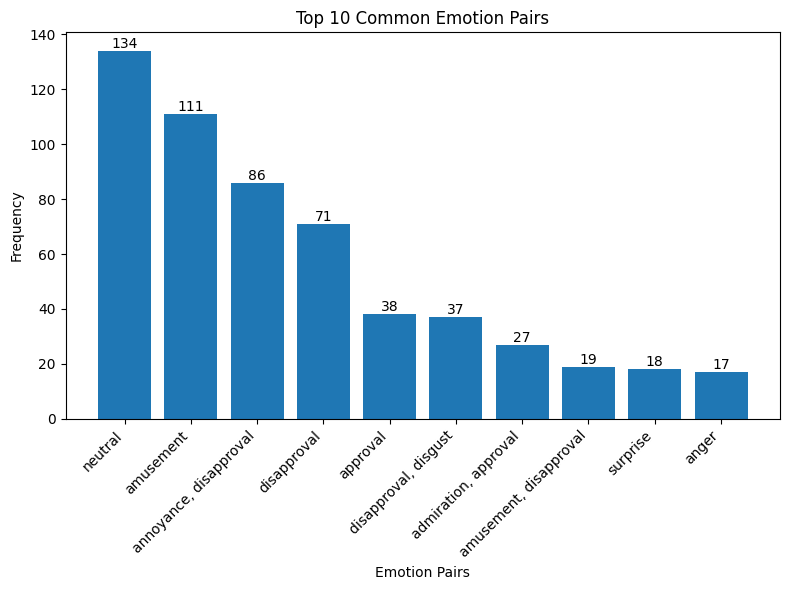

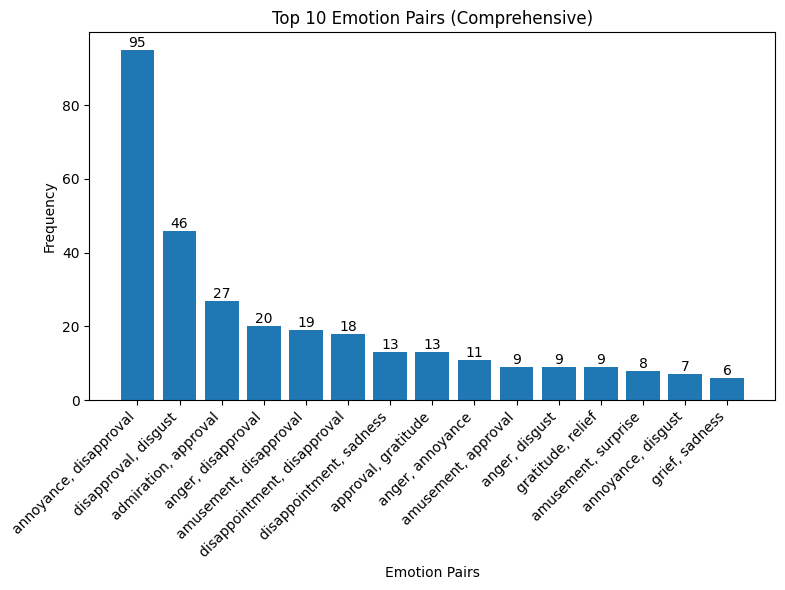

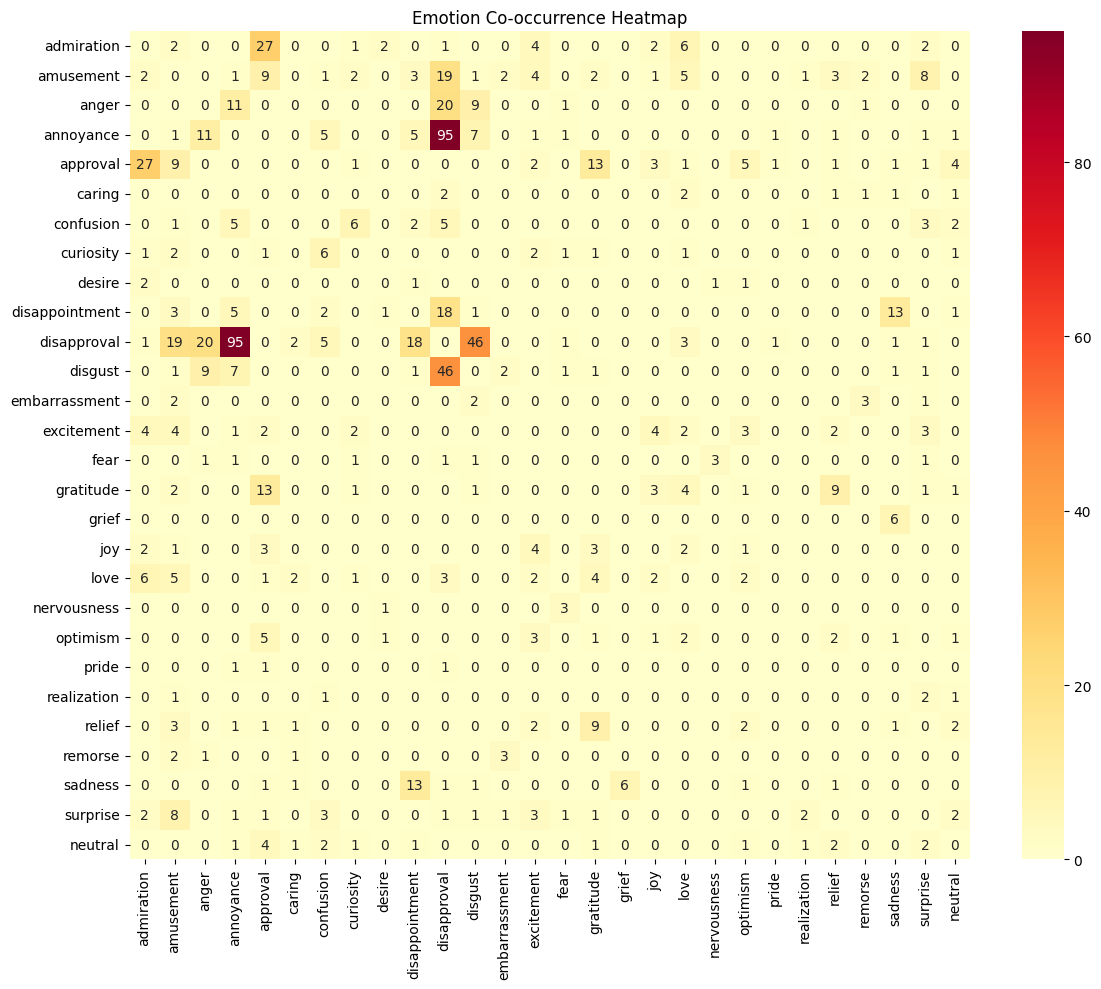

In [50]:
# Main execution
run_number = 3
set_ = 'train'
run_label = 'neutralized'
file_path = f'run{run_number}/{set_}_{run_label}_filtered.csv' 
data = process_csv(file_path)

Number = 10
Print_Table = False

top_pairs = get_top_pairs(data, n=Number)
all_emotion_pairs = get_all_emotion_pairs(data)
# plot and save 
plot_top_pairs(top_pairs, f"Top {Number} Common Emotion Pairs", run_number, save=True, set_=set_)
plot_top_pairs(all_emotion_pairs, f"Top {Number} Emotion Pairs (Comprehensive)", run_number, save=True, set_=set_)
plot_heatmap(get_all_emotion_pairs(data, n=len(EMOTIONS)**2), run_number, save=True, set_=set_)

#save all the plots


if Print_Table:
    print_table(top_pairs, f"Top {Number} Common Pairs")
    print_table(all_emotion_pairs, f"Top {Number} Pairs of Emotions (Comprehensive)")


Average BCE Loss: 0.1481
Average F1 Score: 0.5050
Average Precision: 0.6660
Average Recall: 0.4394


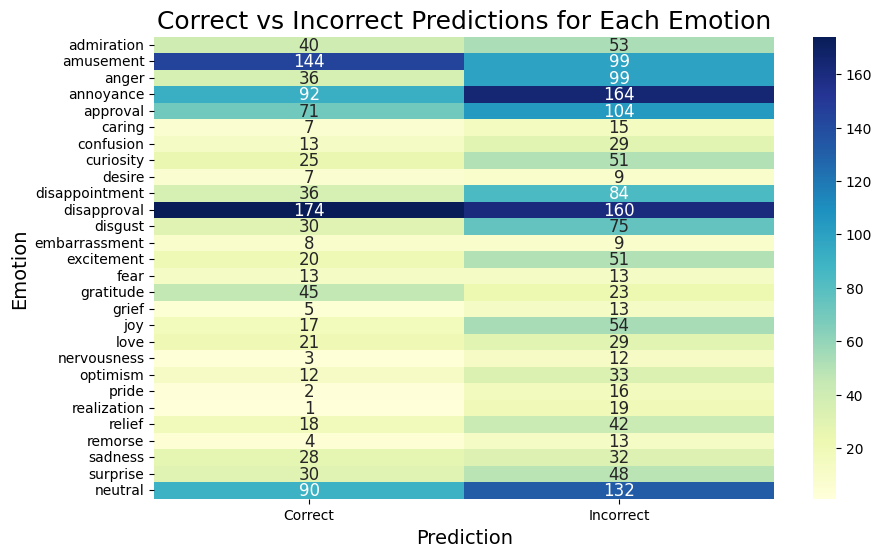

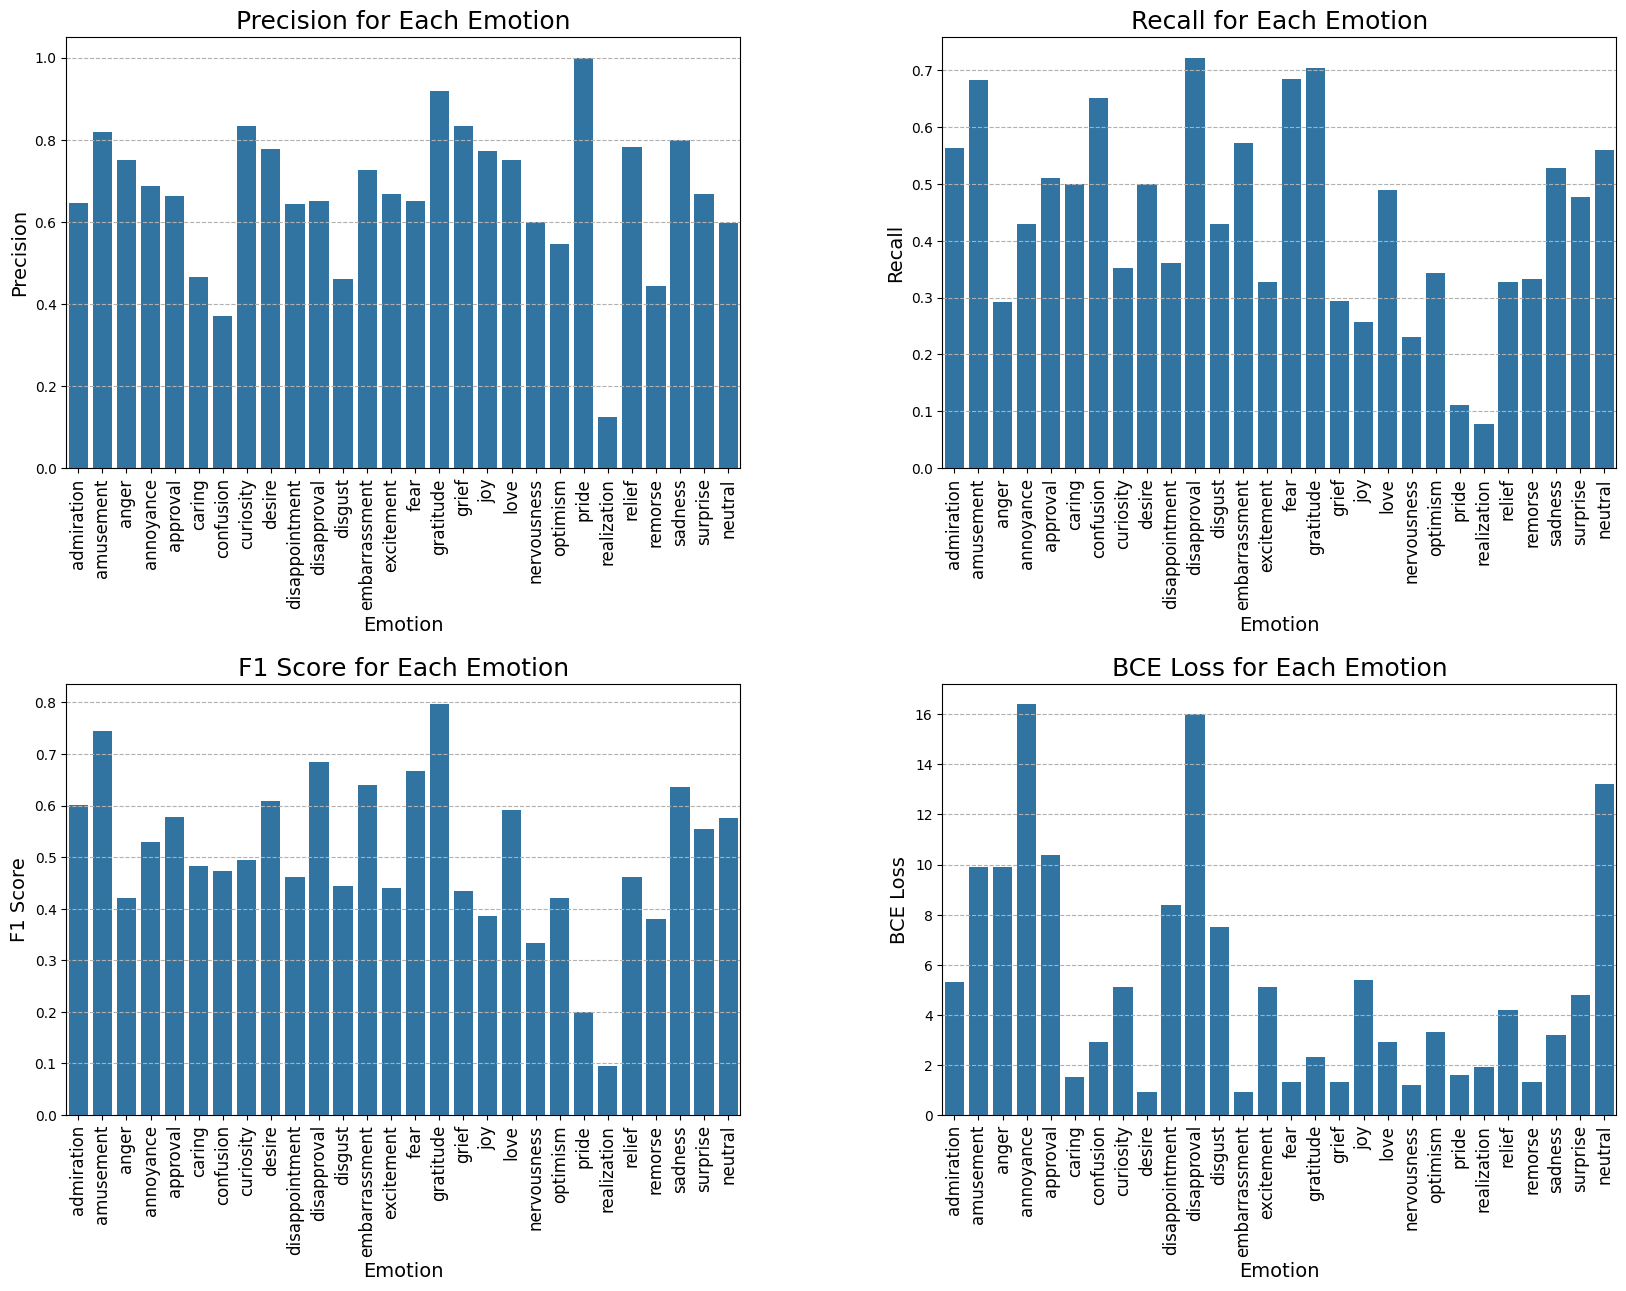

In [52]:
import ast
from dataset_utils import visualize_emotion_data
from dataset_utils import calculate_metrics

run1 = pd.read_csv("run2/train_neutralized_filtered.csv")
run2 = pd.read_csv("run3/train_neutralized_filtered.csv")
# drop duplicate texts of both runs
run1.drop_duplicates(subset = "text", inplace = True)
run2.drop_duplicates(subset = "text", inplace = True)

run1 = run1[run1["text"].isin(run2["text"])]
# order both runs
run1 = run1.sort_values("text")
run2 = run2.sort_values("text")

# list of lists of labels
labels1 = run1["parsed_predictions"].apply(lambda x: ast.literal_eval(x)).tolist()
labels2 = run2["parsed_predictions"].apply(lambda x: ast.literal_eval(x)).tolist()

scores = calculate_metrics(labels2, labels1, EMOTIONS)

print(f"Average BCE Loss: {scores['average']['bce']:.4f}")
print(f"Average F1 Score: {scores['average']['f1']:.4f}")
print(f"Average Precision: {scores['average']['precision']:.4f}")
print(f"Average Recall: {scores['average']['recall']:.4f}")


visualize_emotion_data(scores)

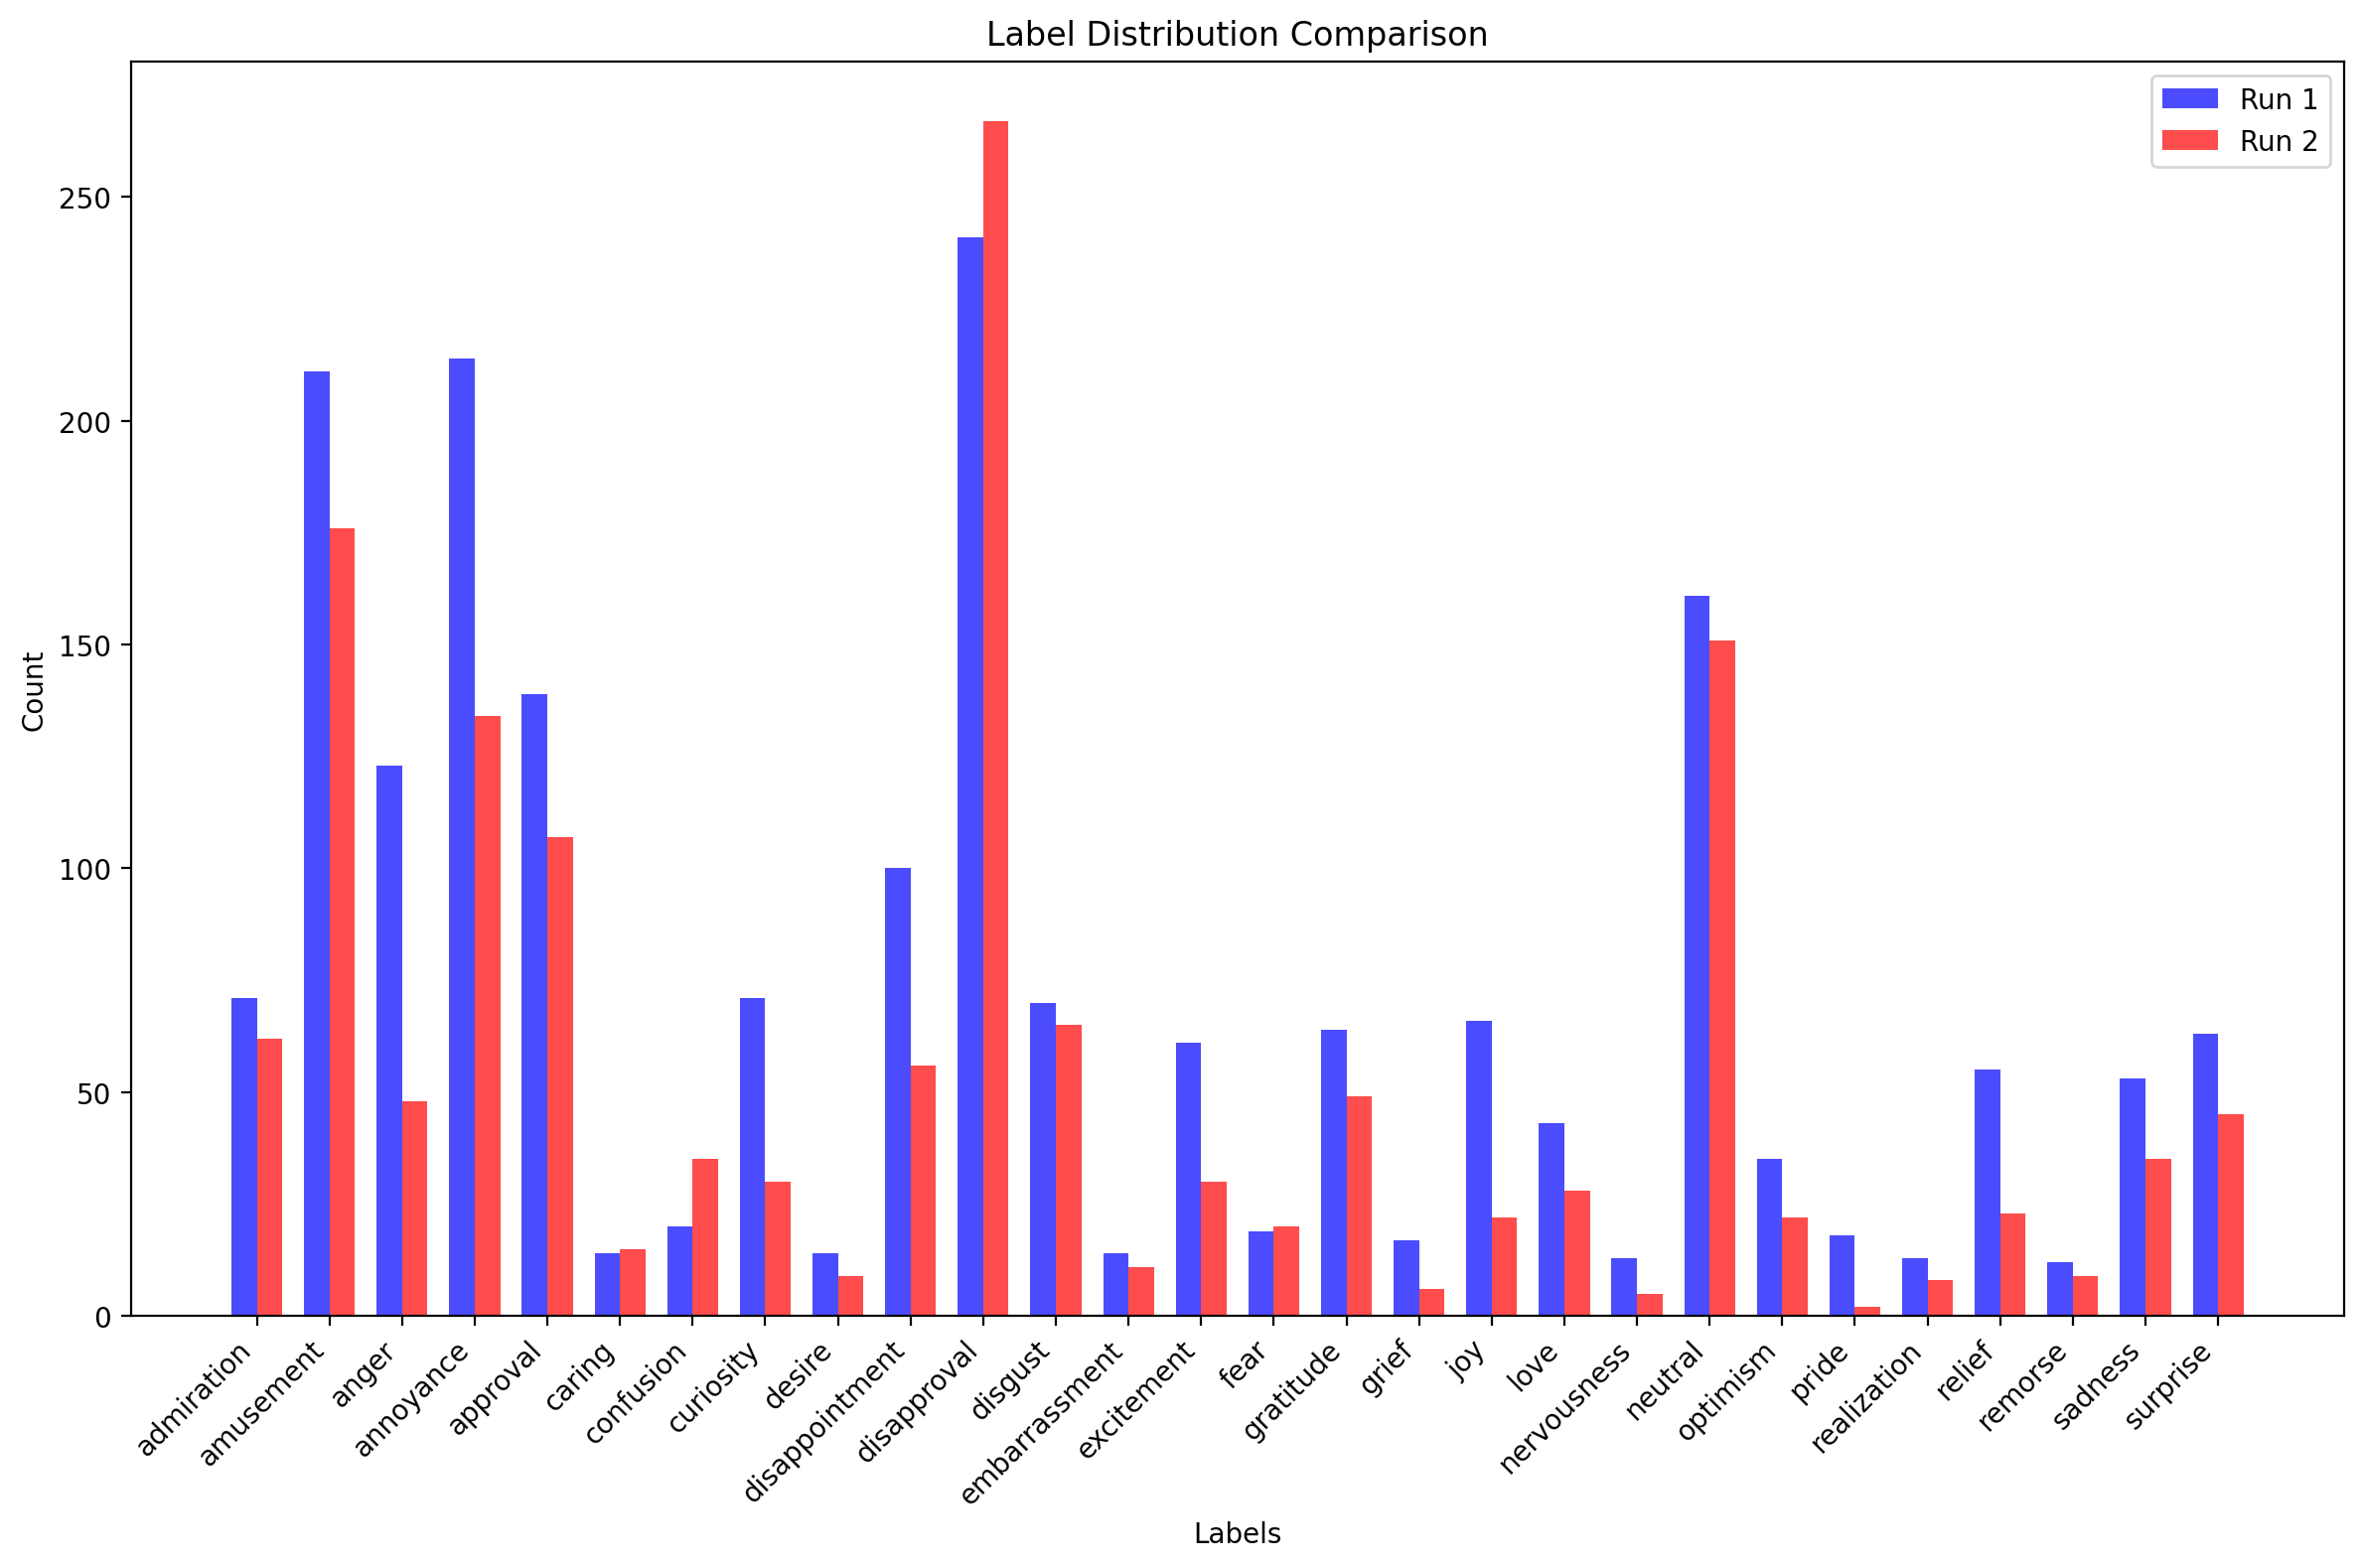

In [53]:
import matplotlib.pyplot as plt


# make a dictionary for the number of times each label was used
label_counts_run1 = {}
for labels in labels1:
    for label in labels:
        if label in label_counts_run1:
            label_counts_run1[label] += 1
        else:
            label_counts_run1[label] = 1

label_counts_run2 = {}
for labels in labels2:
    for label in labels:
        if label in label_counts_run2:
            label_counts_run2[label] += 1
        else:
            label_counts_run2[label] = 1

# Get all unique labels from both runs
all_labels = sorted(set(list(label_counts_run1.keys()) + list(label_counts_run2.keys())))

# Create lists of counts, filling in 0 for missing labels
counts_run1 = [label_counts_run1.get(label, 0) for label in all_labels]
counts_run2 = [label_counts_run2.get(label, 0) for label in all_labels]

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8), dpi=200)

# Plot bars for both runs
bar_width = 0.35
index = range(len(all_labels))
ax.bar(index, counts_run1, bar_width, label='Run 1', color='blue', alpha=0.7)
ax.bar([i + bar_width for i in index], counts_run2, bar_width, label='Run 2', color='red', alpha=0.7)

# Customize the plot
ax.set_xlabel('Labels')
ax.set_ylabel('Count')
ax.set_title('Label Distribution Comparison')
ax.set_xticks([i + bar_width/2 for i in index])
ax.set_xticklabels(all_labels, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()

Shannon Entropy - Run 1: 4.2705
Shannon Entropy - Run 2: 4.0699
Gini Coefficient - Run 1: 0.4724
Gini Coefficient - Run 2: 0.5422


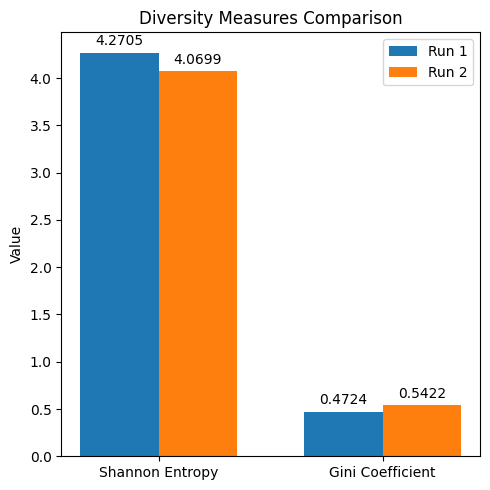

In [54]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_shannon_entropy(label_counts):
    total = sum(label_counts.values())
    probabilities = [count / total for count in label_counts.values()]
    return -sum(p * np.log2(p) for p in probabilities if p > 0)

def calculate_gini_coefficient(label_counts):
    total = sum(label_counts.values())
    proportions = sorted([count / total for count in label_counts.values()])
    cumulative_proportions = np.cumsum(proportions)
    n = len(proportions)
    return (n + 1 - 2 * np.sum(cumulative_proportions)) / n

# Assuming label_counts_run1 and label_counts_run2 are already defined

# Calculate diversity measures
entropy_run1 = calculate_shannon_entropy(label_counts_run1)
entropy_run2 = calculate_shannon_entropy(label_counts_run2)

gini_run1 = calculate_gini_coefficient(label_counts_run1)
gini_run2 = calculate_gini_coefficient(label_counts_run2)

# Print results
print(f"Shannon Entropy - Run 1: {entropy_run1:.4f}")
print(f"Shannon Entropy - Run 2: {entropy_run2:.4f}")
print(f"Gini Coefficient - Run 1: {gini_run1:.4f}")
print(f"Gini Coefficient - Run 2: {gini_run2:.4f}")

# Visualize results
measures = ['Shannon Entropy', 'Gini Coefficient']
run1_values = [entropy_run1, gini_run1]
run2_values = [entropy_run2, gini_run2]

x = np.arange(len(measures))
width = 0.35

fig, ax = plt.subplots(figsize=(5, 5))
rects1 = ax.bar(x - width/2, run1_values, width, label='Run 1')
rects2 = ax.bar(x + width/2, run2_values, width, label='Run 2')

ax.set_ylabel('Value')
ax.set_title('Diversity Measures Comparison')
ax.set_xticks(x)
ax.set_xticklabels(measures)
ax.legend()

ax.bar_label(rects1, padding=3, fmt='%.4f')
ax.bar_label(rects2, padding=3, fmt='%.4f')

fig.tight_layout()
plt.show()

In [9]:
# average number of labels per comment
average_labels_run1 = sum(label_counts_run1.values()) / len(labels1)
average_labels_run2 = sum(label_counts_run2.values()) / len(labels2)

print(f"Average number of labels per comment - Run 1: {average_labels_run1:.4f}")
print(f"Average number of labels per comment - Run 2: {average_labels_run2:.4f}")

Average number of labels per comment - Run 1: 1.9840
Average number of labels per comment - Run 2: 1.9950


In [30]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from tqdm import tqdm

tokenizer = AutoTokenizer.from_pretrained("0ssamaak0/roberta-base-LEGO_emotions")
model = AutoModelForSequenceClassification.from_pretrained("0ssamaak0/roberta-base-LEGO_emotions")

run0 = pd.DataFrame({
    "text", "parsed_predictions"
})

for text in tqdm(run1["text"], desc="Processing texts"):
    encoded_input = tokenizer(text, return_tensors='pt')
    with torch.no_grad():
        output = model(**encoded_input)
    probabilities = torch.sigmoid(output.logits).squeeze().tolist()
    predictions = [EMOTIONS[i] for i, prob in enumerate(probabilities) if prob > 0.5]
    new_row = pd.DataFrame({"text": [text], "parsed_predictions": [predictions]})
    # Append the new row to run0 using pd.concat
    run0 = pd.concat([run0, new_row], ignore_index=True)



Processing texts: 100%|██████████| 1000/1000 [00:47<00:00, 21.23it/s]
